# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
7.3.2023<br>
Team 8. Joona Nylander, Lassi Piispanen, Antti Taponen<br>
[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

The goal of this notebook is to use methods of text processing and create classifier with Recurrent Neural Network (LSTM) and Convolutional 1D Neural Network to see if they can predict the rating of the drug based on the review. If they can we compare the results which model performs better on this particular task.

## 2. Setup

The main library used to process the data and build the Recurrent Neural Network and the Convolutional 1D Neural Network is Tensorflows Keras library.
Pandas and Numpy libraries are used to load and fetch the necessary data from the dataset. Matplotlib.pyplot is imported for performance and result visualization.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Dataset

The dataset used in this notebook is [UCI ML Drug Review dataset](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018) which consist of data extracted from [Drugs.com](https://www.drugs.com/).

The dataset contains the following information:

*   ID of the review
*   Name of the drug
*   Reviewers condition
*   Review
*   Rating
*   Date
*   Usefulness of the review given by other users

Useful data in terms of this notebook are the reviews itself and the corresponding ratings.

In [ ]:
# Reading of train and test sets as Pandas Dataframes from Google Drive
train = pd.read_csv('/content/drive/Shareddrives/Neuroverkot/Juha/case3/drugsComTrain_raw.csv')
test = pd.read_csv('/content/drive/Shareddrives/Neuroverkot/Juha/case3/drugsComTest_raw.csv')

In [ ]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


## 4. Preprocessing

Preprocessing steps takens:
- A tokenizer was created and the reviews were fit through it. This creates a word list of the most common 4000 words that appear in the data, in addition the tokenizer removes the special characters and formats the text to lowercase form.
- A data sequence length of 100 is chosen so all reviews are truncated to 100 if longer or padded to 100 if shorter.
- The review scores are categorized to "negative" if rating is below 5, "neutral" if rating is 5 or 6 and "positive" if rating is above 6. Finally these categories are one hot encoded.

In [ ]:
#Tokenization and data sequence specification for training set and the test set
tokenizer = Tokenizer(num_words = 4000)
tokenizer.fit_on_texts(train["review"])
sequences = tokenizer.texts_to_sequences(train["review"])
data = pad_sequences(sequences, maxlen = 100)

test_tokenizer = Tokenizer(num_words = 4000)
test_tokenizer.fit_on_texts(test["review"])
test_sequences = tokenizer.texts_to_sequences(test["review"])
test_data = pad_sequences(test_sequences, maxlen = 100)

In [ ]:
## Rescale rating values to be 0 if rating < 5, 1 if rating == 5 | 6, 2 if > 6 for both the test set and the training set

train.loc[train["rating"] < 5, "rating"] = 0
train["rating"] = np.where((train["rating"] == 5) | (train["rating"] == 6), 1, train["rating"])
train.loc[train["rating"] > 6, "rating"] = 2

test.loc[test["rating"] < 5, "rating"] = 0
test["rating"] = np.where((test["rating"] == 5) | (test["rating"] == 6), 1, test["rating"])
test.loc[test["rating"] > 6, "rating"] = 2

In [ ]:
#One hot encoding the rating categories
ratings = train["rating"].values
ratings = to_categorical(ratings)


test_ratings = test["rating"].values
test_ratings = to_categorical(test_ratings)
test_ratings[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## 5. Modeling

2 different models we chose for the problem are a Long short-term memory recurrent neural network (LSTM RNN) and a 1-dimensional convolutional neural network (1D CNN).

With both models we used Categorical crossentropy for the loss functions. For RNN Nadam optimizer yielded slightly better results and for CNN adam was slightly better. 

The RNN model is a sequential model which consisted of an Embedding layer, LSTM layer with dropout and recurrent dropout and a Dense layer using softmax as the activation layer.

The CNN model is a sequential model which consisted of an Embedding layer, Conv1D layer using ReLU, MaxPooling1D layer, another Conv1D layer with ReLU, GlobalMaxPooling1D layer and finally a Dense layer using softmax.

In [ ]:
#Building the models
#LSTM RNN
RNNmodel = Sequential()
RNNmodel.add(Embedding(4000, 30, input_length = 100))
RNNmodel.add(LSTM(20, dropout=0.2, recurrent_dropout=0.15))
RNNmodel.add(Dense(3, activation='softmax'))

#1D ConvNN
convmodel = Sequential()
convmodel.add(Embedding(4000, 32, input_length = 100))
convmodel.add(Conv1D(32, 5, activation='relu'))
convmodel.add(Dropout(0.1))
convmodel.add(MaxPooling1D(3))
convmodel.add(Conv1D(32, 5, activation='relu'))
convmodel.add(GlobalMaxPooling1D())
convmodel.add(Dense(3, activation='softmax'))

In [ ]:
#Compiling the models
RNNmodel.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['acc'])

convmodel.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
RNNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 30)           120000    
                                                                 
 lstm (LSTM)                 (None, 20)                4080      
                                                                 
 dense (Dense)               (None, 3)                 63        
                                                                 
Total params: 124,143
Trainable params: 124,143
Non-trainable params: 0
_________________________________________________________________


In [ ]:
convmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           128000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            5152      
                                                                 
 dropout (Dropout)           (None, 96, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 32)            5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                       

## 6. Training

The CNN and RNN models are trained, both models train for around 10 minutes so it results in a good comparison.

In [ ]:
RNNhistory = RNNmodel.fit(data, ratings, epochs=9, batch_size=512, validation_split=0.2, verbose = -1)
CNNhistory = convmodel.fit(data, ratings, epochs=15, batch_size=512, validation_split=0.2, verbose = -1)

Epoch 1/9
Epoch 2/9
Epoch 3/9
Epoch 4/9
Epoch 5/9
Epoch 6/9
Epoch 7/9
Epoch 8/9
Epoch 9/9
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


## 7. Performance and evaluation

As we can read from the following graphs depicting the validation loss and the validation accuracy of both the RNN and CNN mdels, the models are not overfitting, but on the contrary, the validation accuracy could possibly benefit from even more training. In the end as the goal of the project was to compare between the models so we ended the training at around 10 minute mark resulting in decent models.

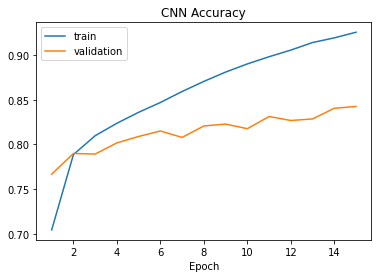

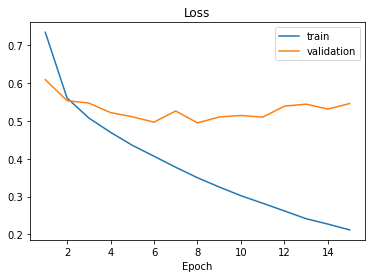

In [ ]:
acc = CNNhistory.history['acc']
val_acc = CNNhistory.history['val_acc']
time = np.arange(len(acc)) + 1

plt.plot(time, acc, label='train')
plt.plot(time, val_acc, label='validation')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

loss = CNNhistory.history['loss']
val_loss = CNNhistory.history['val_loss']
time = np.arange(len(loss)) + 1


plt.plot(time, loss, label='train')
plt.plot(time, val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

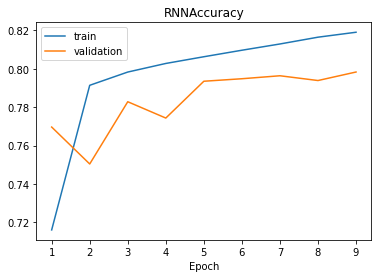

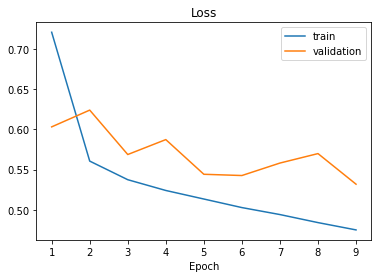

In [ ]:
acc = RNNhistory.history['acc']
val_acc = RNNhistory.history['val_acc']
time = np.arange(len(acc)) + 1

plt.plot(time, acc, label='train')
plt.plot(time, val_acc, label='validation')
plt.title('RNNAccuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

loss = RNNhistory.history['loss']
val_loss = RNNhistory.history['val_loss']
time = np.arange(len(loss)) + 1


plt.plot(time, loss, label='train')
plt.plot(time, val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

Applying the models to a test set:

In [ ]:
CNNpredictions = np.argmax(convmodel.predict(test_data), axis = 1)
RNNpredictions = np.argmax(RNNmodel.predict(test_data), axis = 1)
test_labels = np.argmax(test_ratings, axis = 1)

print('cnn predictions: \n', CNNpredictions[:30])
print('rnn predictions: \n', RNNpredictions[:30])
print('real values: \n', test_labels[:30])

1681/1681 [==============================] - 17s 10ms/step
cnn predictions: 
 [2 2 2 2 2 2 0 2 2 0 0 2 0 2 0 2 2 0 2 2 2 2 0 0 2 1 2 2 2 2]
rnn predictions: 
 [2 2 2 2 2 2 0 2 2 0 0 2 0 2 2 2 2 0 2 2 2 2 2 0 1 2 2 2 0 2]
real values: 
 [2 2 2 2 2 0 1 2 2 0 0 1 0 2 0 2 2 0 1 2 0 2 0 0 2 1 2 2 2 2]


In [ ]:
CNNcr = classification_report(test_labels,CNNpredictions)
print(CNNcr)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     13497
           1       0.56      0.25      0.35      4829
           2       0.88      0.94      0.91     35440

    accuracy                           0.84     53766
   macro avg       0.74      0.66      0.68     53766
weighted avg       0.83      0.84      0.83     53766



In [ ]:
RNNcr = classification_report(test_labels,RNNpredictions)
print(RNNcr)

              precision    recall  f1-score   support

           0       0.70      0.75      0.73     13497
           1       0.29      0.07      0.11      4829
           2       0.85      0.92      0.88     35440

    accuracy                           0.80     53766
   macro avg       0.61      0.58      0.57     53766
weighted avg       0.76      0.80      0.77     53766



Here are the confusion matrices for both models:

In [ ]:
# Calculate the confusion matrix
CNNcm = confusion_matrix(test_labels,CNNpredictions).T
print('CNN confusion matrix: \n',CNNcm)
RNNcm = confusion_matrix(test_labels,RNNpredictions).T
print('\nRNN confusion matrix: \n',RNNcm)

CNN confusion matrix: 
 [[10710  1273  1504]
 [  453  1217   518]
 [ 2334  2339 33418]]

RNN confusion matrix: 
 [[10175  1691  2576]
 [  390   333   430]
 [ 2932  2805 32434]]


We can read from these Cohen's Kappa values that the CNN model is performing better for this problem.

In [ ]:
CNN_c_kappa = cohen_kappa_score(CNNpredictions, test_labels)
CNN_c_kappa2 = cohen_kappa_score(CNNpredictions, test_labels, weights = 'quadratic')
RNN_c_kappa = cohen_kappa_score(RNNpredictions, test_labels)
RNN_c_kappa2 = cohen_kappa_score(RNNpredictions, test_labels, weights = 'quadratic')
print('CNN kappa: ',CNN_c_kappa)
print('RNN kappa: ',RNN_c_kappa)
print('CNN quadratic kappa: ',CNN_c_kappa2)
print('RNN quadratic kappa: ',RNN_c_kappa2)

CNN kappa:  0.6641812908638727
RNN kappa:  0.5648909191592035
CNN quadratic kappa:  0.7521515405313534
RNN quadratic kappa:  0.6672240647999894


## 8. Discussion and conclusions

Conducted experiments:
  - Depth of LSTM layer
  - Embedding dimensions
  - Optimizer
  - Word list length
  - Data sequence length
  - Epoch count
  - Different batch sizes, 256/512/2048
  - Dropout vs no dropout, different dropout and recurrent dropout values (0.05/0.1/0.2)
  - Multiple LSTM layers
<br><br>The following Excel sheet depicts the validation accuracies with different hyperparameters ran on a RNN test model:

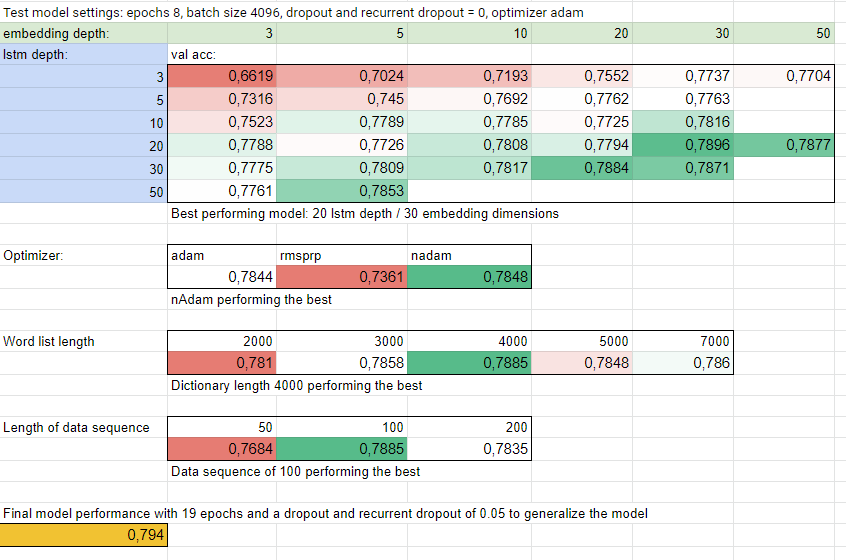

Our first thoughts were that the RNN model would perform better on this task but the Convolutional 1D Neural Network performed better.

Comparing the performance of the models to a dummy classifier, ~66% of all the datapoints in the test set belong to class 2 so a dummy classifier we are comparing to sorts with an accuracy of 66%. From the classification reports printed above at chapter 7 we can see that the CNN model has an accuracy of ~84% and RNN model has an accuracy of ~80%.

In the future the model could be experimented more with and made more complex for example by using both Conv1D and MaxPooling layers aswell as LSTM layers in the same model. Also adding more Dense layers could be worth experimenting with.

Main learning points from the project were the general use of both conv1D and LSTM RNN models for neural networks dealing with text based data. Cohen's kappa score was also a new metric for assessing a model. The final best model created reached a Cohen's kappa score of ~0.664.